# Amazon SageMaker Batch Transform: Associate prediction results with their corresponding input records


## 0. Introduction

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/sagemaker_batch_transform|batch_transform_associate_predictions_with_input|Batch Transform - breast cancer prediction with high level SDK.ipynb)

---
_**Use SageMaker's XGBoost to train a binary classification model and for a list of patients' records in batch file, predict if each is diabetic**_

_**It also shows how to use the input output joining / filter feature in Batch transform in details**_

---


### - Background


The purpose of this notebook is to train a model using SageMaker's XGBoost and the Diabetes Health Indicators dataset (from CDC — BRFSS 2015) to illustrate how to run batch inferences and how to use the Batch Transform I/O join feature. UCI's breast cancer diagnostic data set is available at https://www.cdc.gov/brfss/annual_data/annual_2015.html. The data set is also available on Kaggle at https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data. The purpose here is to use this dataset to build a predictve model to provide predictions on whether an individual has diabetes. 



### - Setup

Let's start by specifying:

* The SageMaker role arn used to give training and batch transform access to your data. The snippet below will use the same role used by your SageMaker notebook instance. Otherwise, specify the full ARN of a role with the SageMakerFullAccess policy attached.
* The S3 bucket that you want to use for training and storing model objects.

In [2]:
# !pip3 install -U sagemaker

In [3]:
import os
import boto3
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = "DEMO-diabetes-prediction-xgboost"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### - Data sources

> CDC - 2015 BRFSS https://www.cdc.gov/brfss/annual_data/annual_2015.html.

> _Also see:_ Diabetes Health Indicators Dataset https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data. 

### - Dataset

- Original Dataset: Contains **330 features (columns)** from the **BRFSS**  
- Current Dataset:  Contains **21 features (columns)** (the publisher of the dataset has downsized the number of features based on diabetes disease research regarding factors influencing diabetes disease and other chronic health conditions.   
__________________________________________________________________________________________________________________________

**Important risk factors for diabetes:**  blood pressure (high) , cholesterol (high) , smoking , diabetes , obesity , age , sex , race , diet , exercise , alcohol consumption , BMI , Household Income , Marital Status , Sleep , Time since last checkup , Education , Health care coverage , Mental Health 

### - Dataset Features

- **Diabetes_012**: *Target variable* indicating whether the respondent has diabetes (2), pre-diabetes (1), or no diabetes (0)
- **HighBP**: Binary variable indicating whether the respondent has high blood pressure (1) or not (0)
- **HighChol**: Binary variable indicating whether the respondent has high cholesterol (1) or not (0)
- **CholCheck**: Binary variable indicating whether the respondent has had their cholesterol checked in the past year (1) or not (0)
- **BMI**: Body mass index of the respondent, calculated as weight in kilograms divided by height in meters squared
- **Smoker**: Binary variable indicating whether the respondent is a current smoker (1) or not (0)
- **Stroke**: Binary variable indicating whether the respondent has had a stroke (1) or not (0)
- **HeartDiseaseorAttack**: Binary variable indicating whether the respondent has had heart disease or a heart attack (1) or not (0)
- **PhysActivity**: Binary variable indicating whether the respondent engages in regular physical activity (1) or not (0)
- **Fruits**: Consume Fruit 1 or more times per day 0 = no 1 = yes
- **Veggies**: Consume Vegetables 1 or more times per day 0 = no 1 = yes
- **HvyAlcoholConsump**: Binary variable indicating whether the respondent engages in heavy alcohol consumption (1) or not (0)
- **AnyHealthcare**: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
- **NoDocbcCost**: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
- **GenHlth**: Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
- **MentHlth**: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?
- **PhysHlth**: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good?
- **DiffWalk**: Binary variable indicating whether the respondent has difficulty walking (1) or not (0)
- **Sex**: Binary variable indicating the gender of the respondent (1 for male, 0 for female)
- **Age**: 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older
- **Education**: Level of education attained by the respondent (1 for less than high school, 2 for high school or equivalent, 3 for some college, and 4 for college graduate or higher)
- **Income**: Annual household income of the respondent, reported in US dollars

### - Dataset Loading

Let's upload the data from the diabetes_012_health_indicators_BRFSS2015.csv (in the local folder) and take a look at it.

In [4]:
import pandas as pd
import numpy as np

s3 = boto3.client("s3")

filename = "diabetes_012_health_indicators_BRFSS2015.csv"
# s3.download_file(
#     f"sagemaker-example-files-prod-{region}", "datasets/tabular/breast_cancer/wdbc.csv", filename
# )
df = pd.read_csv(filename)
df.sample(8)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
195045,0.0,1.0,1.0,1.0,26.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,10.0,5.0,6.0
43716,2.0,0.0,1.0,1.0,35.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,0.0,30.0,0.0,1.0,7.0,6.0,7.0
17675,0.0,1.0,0.0,1.0,34.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,3.0,1.0,0.0,0.0,0.0,3.0,5.0,7.0
129397,0.0,0.0,0.0,0.0,22.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,5.0,30.0,30.0,0.0,0.0,13.0,5.0,4.0
87628,0.0,1.0,1.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,10.0,5.0,4.0
92505,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
55790,0.0,1.0,0.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,30.0,1.0,0.0,9.0,4.0,6.0
134149,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,8.0


#### Key observations:
* The data has 253680 observations and 22 columns.
* The first field is the 'target variable', whiich is an indicator of the actual diabetes status of the patient: diabetes (2), pre-diabetes (1), or no diabetes (0).
* There are 21 other numeric features that we will use for training and inferencing.

## 1. PreProcessing

In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
# from ydata_profiling import ProfileReport
import math

import os,sys,warnings
if not sys.warnoptions:    
    warnings.simplefilter('ignore')

### 1. EDA

#### - Missing Values

In [6]:
# Funtion to check the missing value count and percentage   
def missing_data_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data

In [7]:
missing_data_check(df)

if missing_data_check(df)['Total'].sum() == 0:
    print("No Missing Value found")

No Missing Value found


In [8]:
df.shape

(253680, 22)

Let's split the data as follows: 80% for training, 10% for validation and let's set 10% aside for our batch inference job. In addition, let's drop the 'id' field on the training set and validation set as 'id' is not a training feature. For our batch set however, we keep the 'id' feature. We'll want to filter it out prior to running our inferences so that the input data features match the ones of training set and then ultimately, we'll want to join it with inference result. We are however dropping the diagnosis attribute for the batch set since this is what we'll try to predict.

#### - Stats

In [9]:
df.describe(percentiles=[0.1, 0.25, 0.75, 0.9, 0.95])

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
10%,0.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,3.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
90%,2.000000,1.000000,1.000000,1.000000,36.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,10.000000,20.000000,1.000000,1.000000,12.000000,6.000000,8.000000
95%,2.000000,1.000000,1.000000,1.000000,40.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,4.000000,26.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


**Key Highlights**

- We cant find anything suspicious at first look from data description.
- Roughly 25% of the population in this dataset has highBP and cholestrol
- Roughly 50% of the population in this dataset is non smoker
- 90 percentile of the population has not encountered heart attach in the past
- More than 75 percentile population engages in physical activites
- More than 50% of the population eats fruits and vegetables everyday. 
- Roughly 5% of the population heavy alcohol consumer.
- Less than 10% of the population doesnt hold any healthcare.
- 75% of the population have reported excellent to good general health.
- Close to 75% of the population have reported that we physically, mentally ill less than 2-3 days during past 30 days.
- Roughly 10% of the people reported difficulty in walking
- Less than 5% of the population reported stroke while roughly 5% of the population reported heart disease or Attack in thee past
- It seems we have 50-50 split of males and females, which we can double check.

In [10]:
duplicates = df[df.duplicated()]
print("Total Duplicates rows observed:", df.shape[0])
print("Dropping duplicates - If each field is exactly same as this wont add any value to the model")

# Dropping duplicates
print("Shape before dropping duplicates : ", df.shape[0])
df.drop_duplicates(inplace = True)
print("Shape after dropping duplicates : ", df.shape[0])

Total Duplicates rows observed: 253680
Dropping duplicates - If each field is exactly same as this wont add any value to the model
Shape before dropping duplicates :  253680
Shape after dropping duplicates :  229781


#### - Data Types

In [11]:
# checking unique values in different variables
data_types = {}
unique_value_counts = {}
unique_values = {}
for col in df.columns:
    data_types[col] = df[col].dtype
    unique_value_counts[col] = df[col].nunique()
    unique_values[col] = df[col].unique().tolist()

# pd.DataFrame(unique_values, index=['unique value count']).transpose()
# Create a DataFrame from the dictionaries
df_info = pd.DataFrame({
    'data_type': data_types,
    'unique_value_count': unique_value_counts,
    'unique_values': unique_values
})
df_info

,data_type,unique_value_count,unique_values
Diabetes_012,float64,3,"[0.0, 2.0, 1.0]"
HighBP,float64,2,"[1.0, 0.0]"
HighChol,float64,2,"[1.0, 0.0]"
CholCheck,float64,2,"[1.0, 0.0]"
BMI,float64,84,"[40.0, 25.0, 28.0, 27.0, 24.0, 30.0, 34.0, 26...."
Smoker,float64,2,"[1.0, 0.0]"
Stroke,float64,2,"[0.0, 1.0]"
HeartDiseaseorAttack,float64,2,"[0.0, 1.0]"
PhysActivity,float64,2,"[0.0, 1.0]"
Fruits,float64,2,"[0.0, 1.0]"


In [12]:
# Convert all columns to int
df = df.astype(int)

#### - Data Correlation

Text(0.5, 1.0, 'Correlation of Features')

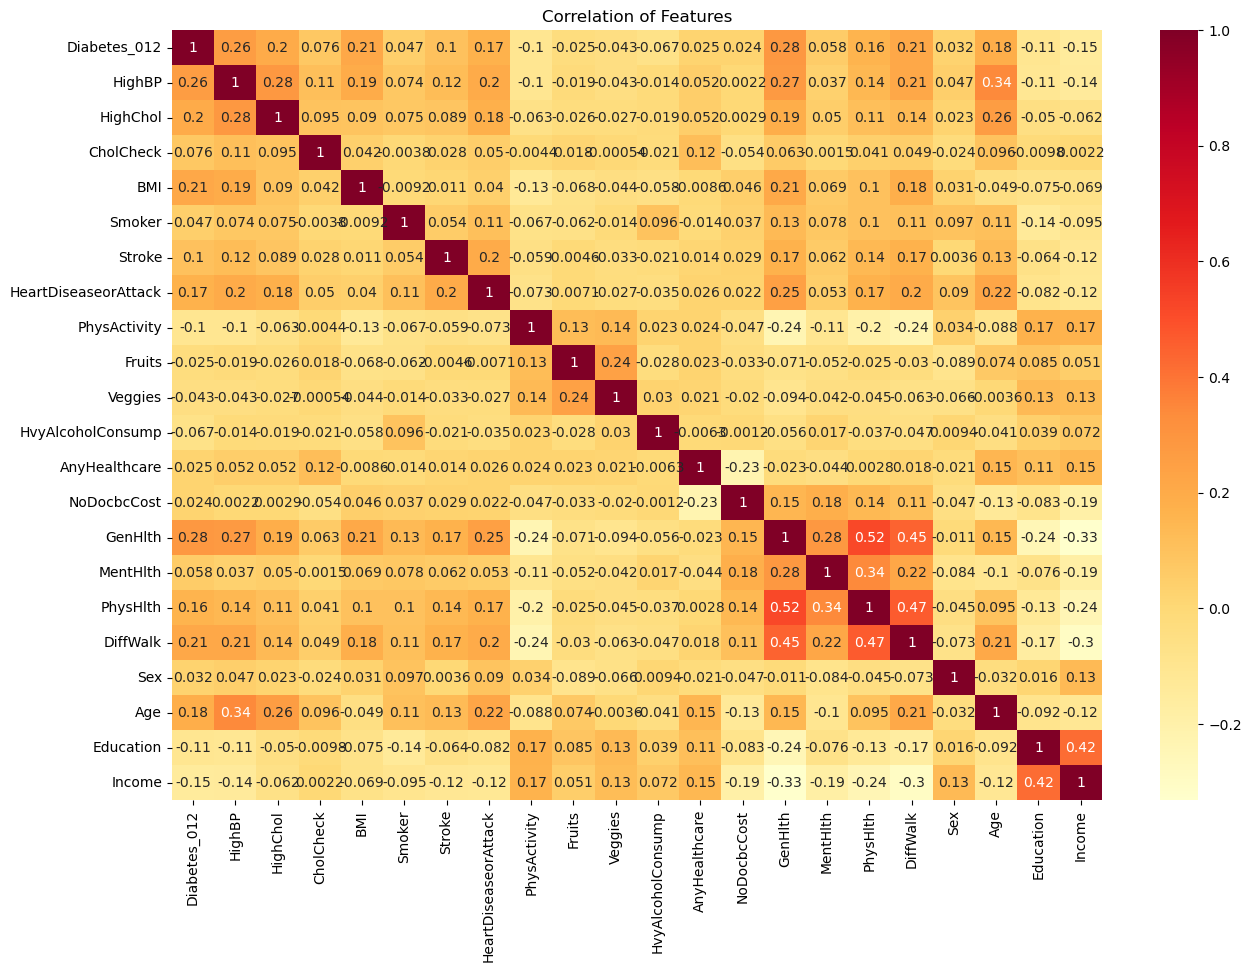

In [13]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot=True , cmap ='YlOrRd' )
plt.title("Correlation of Features")

#### - Dataset Imbalance

In [14]:
# create a new column with binary indicator variable for Diabetes_012
df["Diabetes_binary"] = df["Diabetes_012"].apply(lambda x: 1 if x == 2 else 0)

In [15]:
# Count the number of males and females in the dataset
diab_counts = df['Diabetes_binary'].value_counts()
# Map the counts to their corresponding labels
diab_counts.index = diab_counts.index.map({0: 'Non-Diabetic', 1: 'Diabetic'})

# Print the counts
print("Counts of diabetic vs. non-diabetic patients (in the dataset):")
print(diab_counts)

Counts of diabetic vs. non-diabetic patients (in the dataset):
Diabetes_binary
Non-Diabetic    194684
Diabetic         35097
Name: count, dtype: int64


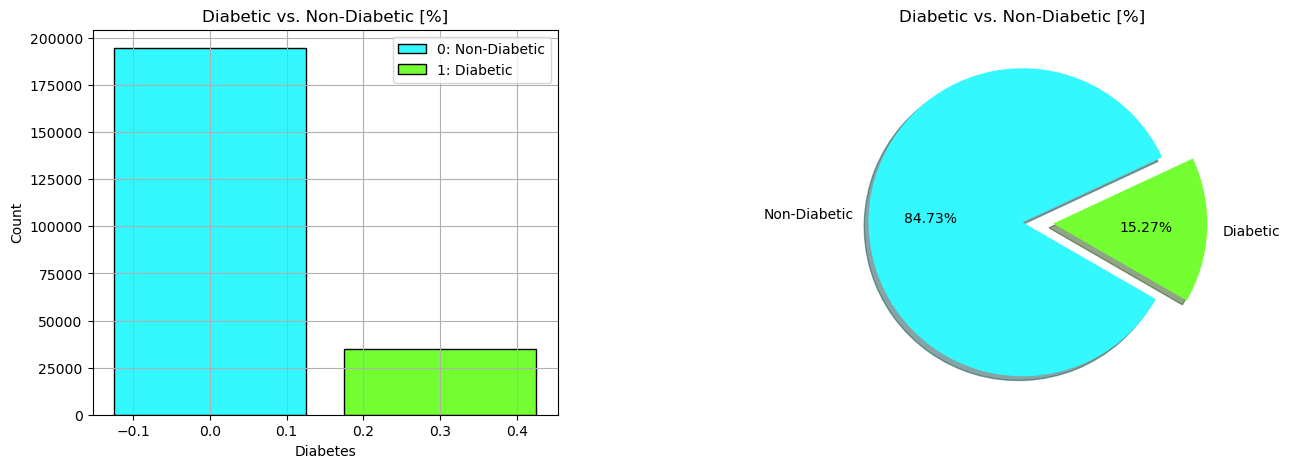

Diabetes: Non-Diabetic = 194684, Diabetic =35097


In [16]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot the first chart (BARPLOT)
# gender_counts
r0 = 0.
r1 = 0.3
bar0 = diab_counts[0]
bar1 = diab_counts[1]
barWidth = 0.25
mycolors = ["#33f9ff", "#74ff33"]
b0 = axs[0].bar(r0, bar0, width = barWidth, color = mycolors[0], edgecolor ='black', capsize=7, label='0')
b1 = axs[0].bar(r1, bar1, width = barWidth, color = mycolors[1], edgecolor ='black', capsize=7, label='1')
axs[0].set_xlabel('Diabetes')
axs[0].set_ylabel('Count')
axs[0].set_title('Diabetic vs. Non-Diabetic [%]')
axs[0].legend(['0: Non-Diabetic','1: Diabetic'])
axs[0].grid()
# Plot the second chart (PIE)
mycolors = ["#33f9ff", "#74ff33"]
mylabels ="Non-Diabetic", "Diabetic"
axs[1].pie(diab_counts, explode=[0,0.2], autopct='%1.2f%%', shadow=True,colors=mycolors,
labels=mylabels, startangle=25)
axs[1].set_title('Diabetic vs. Non-Diabetic [%]')
# Adjust spacing between subplots
plt.subplots_adjust(wspace=.5)
# Display the plot
plt.show()
print(f'Diabetes: Non-Diabetic = {diab_counts[0]}, Diabetic ={diab_counts[1]}')

### 2. Feature Importance

In [17]:
df_original = df.copy()
df = df.drop("Diabetes_012", axis = 1)

#### - Dataset Splitting: SMOTE + Scaling

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and 'target' is the name of your target column
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_sm_scaled = scaler.fit_transform(X_train_sm)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_sm_scaled, y_train_sm)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[48692  9714]
 [ 5865  4664]]
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     58406
           1       0.32      0.44      0.37     10529

    accuracy                           0.77     68935
   macro avg       0.61      0.64      0.62     68935
weighted avg       0.81      0.77      0.79     68935



#### - Feature Importance

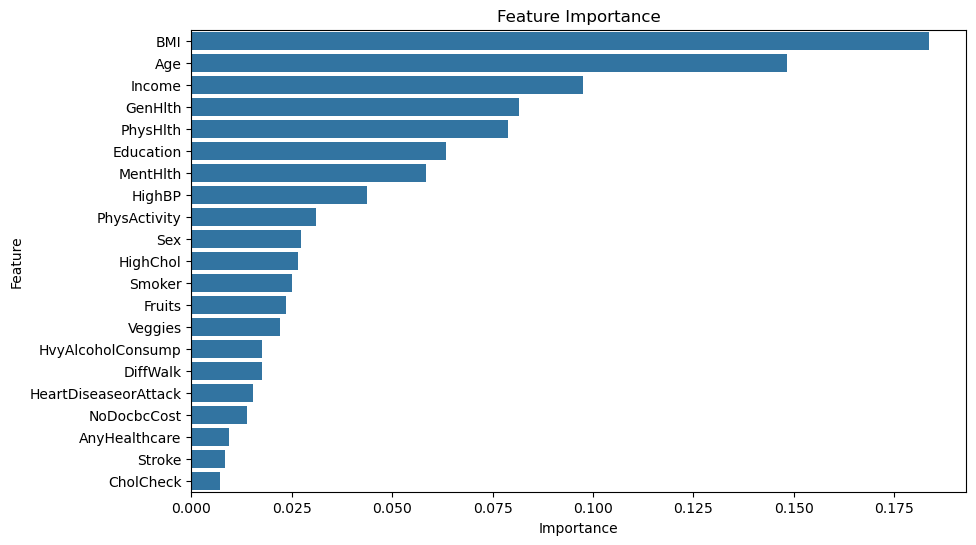

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance')
plt.show()

#### - XGBoost (Quick Check)

In [22]:
# !pip install xgboost

In [23]:
import xgboost as xgb

# Select the important features
important_features = ['BMI', 'Age', 'Income', 'GenHlth', 'PhysHlth', 'Education', 'MentHlth', 'HighBP']
X = df[important_features]
y = df['Diabetes_binary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_sm_scaled, y_train_sm)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[39980 18426]
 [ 2820  7709]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79     58406
           1       0.29      0.73      0.42     10529

    accuracy                           0.69     68935
   macro avg       0.61      0.71      0.61     68935
weighted avg       0.84      0.69      0.73     68935



### 3. Dataset Splitting (for Batch Processing)

#### - SMOTE

In [24]:
# !pip install imblearn

In [26]:
# Select the important features
# important_features = ['BMI', 'Age', 'Income', 'GenHlth', 'PhysHlth', 'Education', 'MentHlth', 'HighBP']
X = df[important_features]
y = df['Diabetes_binary']

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and 'target' is the name of your target column
# X = df.drop(columns=['Diabetes_binary'])
# y = df['Diabetes_binary']

# Initial split: 80% training and 20% test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the test set into validation (10%) and batch inference (10%)
X_val, X_batch_infer, y_val, y_batch_infer = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### - Scaling

In [29]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_sm_scaled = scaler.fit_transform(X_train_sm)

# Transform the validation and batch inference sets
X_val_scaled = scaler.transform(X_val)
X_batch_infer_scaled = scaler.transform(X_batch_infer)

In [82]:
# Convert arrays back to DataFrames
X_train_df = pd.DataFrame(X_train_sm_scaled, columns=X.columns)
X_val_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_batch_infer_df = pd.DataFrame(X_batch_infer_scaled, columns=X.columns)

# Add the target variable back to the DataFrames
train_df = X_train_df.copy()
train_df['Diabetes_binary'] = y_train_sm.values

val_df = X_val_df.copy()
val_df['Diabetes_binary'] = y_val.values

batch_infer_df = X_batch_infer_df.copy()
# batch_infer_df['Diabetes_binary'] = y_batch_infer.values    # Remove the target variable from the batch inference data

In [83]:
data_train = train_df
data_val   = val_df
data_batch = batch_infer_df     # Does NOT contain the 'target variable'

In [84]:
# data_train
target = 'Diabetes_binary'
cols = [target] + [col for col in data_train.columns if col != target]
data_train = data_train[cols]
data_train

,Diabetes_binary,BMI,Age,Income,GenHlth,PhysHlth,Education,MentHlth,HighBP
0,0,-0.549957,-0.540203,1.127230,-0.777864,-0.588651,1.153679,3.152509,-1.096482
1,0,0.010270,-0.892216,1.127230,-0.777864,-0.588651,1.153679,3.152509,-1.096482
2,0,-0.269843,1.219862,-1.616412,-0.777864,-0.097287,1.153679,0.738010,0.912007
3,1,0.430440,0.163823,0.669956,0.179522,-0.293833,0.179275,1.220910,0.912007
4,0,1.410837,0.163823,1.127230,0.179522,0.394077,0.179275,-0.469239,0.912007
...,...,...,...,...,...,...,...,...,...
311489,1,-1.110184,1.571875,-0.244591,2.094295,2.359534,-0.795129,-0.469239,-1.096482
311490,1,-0.549957,1.219862,-1.616412,0.179522,2.359534,-0.795129,3.152509,0.912007
311491,1,0.290383,0.515836,-0.701865,-0.777864,-0.588651,0.179275,1.341635,-1.096482
311492,1,0.850610,1.571875,-0.701865,0.179522,-0.588651,-0.795129,-0.469239,-1.096482


In [85]:
# data_val
target = 'Diabetes_binary'
cols = [target] + [col for col in data_val.columns if col != target]
data_val = data_val[cols]
data_val

,Diabetes_binary,BMI,Age,Income,GenHlth,PhysHlth,Education,MentHlth,HighBP
0,0,-1.250240,-1.948254,1.127230,-0.777864,-0.392106,1.153679,-0.348514,-1.096482
1,0,-1.250240,0.867849,-1.616412,0.179522,-0.588651,-0.795129,-0.469239,-1.096482
2,0,0.010270,-0.540203,1.127230,-0.777864,-0.195560,-0.795129,-0.469239,0.912007
3,0,-1.250240,0.163823,1.127230,-1.735251,-0.097287,1.153679,-0.469239,-1.096482
4,0,-0.409900,0.163823,0.669956,0.179522,-0.588651,1.153679,-0.469239,-1.096482
...,...,...,...,...,...,...,...,...,...
22973,1,0.570497,0.163823,1.127230,-0.777864,-0.588651,0.179275,-0.469239,0.912007
22974,0,0.990667,0.867849,0.212683,0.179522,-0.588651,0.179275,-0.227789,0.912007
22975,0,0.850610,0.163823,0.212683,-0.777864,0.099258,1.153679,0.738010,-1.096482
22976,0,-0.970127,-1.244229,-0.701865,-0.777864,-0.588651,1.153679,-0.469239,-1.096482


Let's upload those data sets in S3

In [87]:
train_file = "train_data.csv"
data_train.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/validation".format(prefix))


# IMPORTANT: The batch must NOT contain the target variable 'Diabetes_binary'
batch_file = "batch_data.csv"
data_batch.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/batch".format(prefix))

's3://sagemaker-us-east-1-333907264027/DEMO-diabetes-prediction-xgboost/batch/batch_data.csv'

---

## Training job and model creation

The below cell uses the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to kick off the training job using both our training set and validation set. Not that the objective is set to 'binary:logistic' which trains a model to output a probability between 0 and 1 (here the probability of a tumor being malignant).

In [88]:
%%time
from time import gmtime, strftime

job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    objective="binary:logistic",
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    num_round=100,
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgb-2024-06-04-02-55-34


2024-06-04 02:55:34 Starting - Starting the training job...
2024-06-04 02:55:50 Starting - Preparing the instances for training...
2024-06-04 02:56:13 Downloading - Downloading input data...
2024-06-04 02:56:38 Downloading - Downloading the training image...
2024-06-04 02:57:18 Training - Training image download completed. Training in progress..[2024-06-04 02:57:28.489 ip-10-2-232-6.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-04 02:57:28.515 ip-10-2-232-6.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-04:02:57:28:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-04:02:57:28:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-06-04:02:57:28:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:02:57:28:INFO] Running XGBoost Sagemaker in algorithm mode
[2024-06-04:02:57:28:INFO] Determined 0 GPU(s) available on the instance.

In [89]:
# Read the lines from the file into a list
with open('logs.txt', 'r') as file:
    log_lines = file.readlines()

In [90]:
import re

# Initialize lists to store the extracted log loss values
train_logloss = []
validation_logloss = []

# Extract the log loss values using regex
for line in log_lines:
    match = re.search(r"train-logloss:([\d.]+)#011validation-logloss:([\d.]+)", line)
    if match:
        train_logloss.append(float(match.group(1)))
        validation_logloss.append(float(match.group(2)))
    else:
        print(f"No match found in line: {line.strip()}")

# Print extracted values to verify
# print("Train Log Loss:", train_logloss)
# print("Validation Log Loss:", validation_logloss)

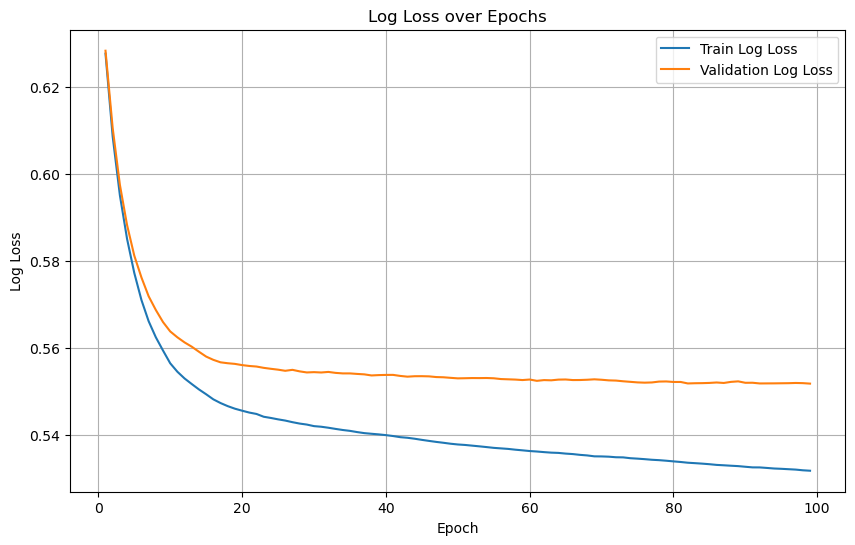

In [91]:
import matplotlib.pyplot as plt

# Assuming train_logloss and validation_logloss are lists of extracted values
epochs = range(1, len(train_logloss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_logloss, label='Train Log Loss')
plt.plot(epochs, validation_logloss, label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


---

## Batch Transform

In SageMaker Batch Transform, we introduced 3 new attributes - __input_filter__, __join_source__ and __output_filter__. In the below cell, we use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to kick-off several Batch Transform jobs using different configurations of these 3 new attributes. Please refer to [this page](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform-data-processing.html) to learn more about how to use them.




#### 1. Create a transform job with the default configurations
Let's first skip these 3 new attributes and inspect the inference results. We'll use it as a baseline to compare to the results with data processing.

In [92]:
%%time

sm_transformer = sm_estimator.transformer(1, "ml.m4.xlarge")

# start a transform job
input_location = "s3://{}/{}/batch/{}".format(
    bucket, prefix, batch_file
)  # use input data without ID column
sm_transformer.transform(input_location, content_type="text/csv", split_type="Line")
sm_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-04-02-59-34-559
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-04-02-59-35-355


..........................................
[2024-06-04:03:06:38:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:06:38:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:06:38:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-04 03:06:38 +0000] [19] [INFO] S

Let's inspect the output of the Batch Transform job in S3. It should show the list probabilities of patients being diabetic.

In [93]:
import re


def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    s3.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [94]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
output_df.head(8)

,0
0,0.045884
1,0.477291
2,0.794710
3,0.191067
4,0.608162
5,0.774165
6,0.673618
7,0.273899


#### 2. Join the input and the prediction results 
Now, let's associate the prediction results with their corresponding input records. We can also use the __input_filter__ to exclude the ID column easily and there's no need to have a separate file in S3.

* Set __input_filter__ to "$[1:]": indicates that we are excluding column 0 (the 'ID') before processing the inferences and keeping everything from column 1 to the last column (all the features or predictors)  
  
  
* Set __join_source__ to "Input": indicates our desire to join the input data with the inference results  

* Leave __output_filter__ to default ('$'), indicating that the joined input and inference results be will saved as output.

In [95]:
# content_type / accept and split_type / assemble_with are required to use IO joining feature
sm_transformer.assemble_with = "Line"
sm_transformer.accept = "text/csv"

# start a transform job
input_location = "s3://{}/{}/batch/{}".format(
    bucket, prefix, batch_file
)  # use input data with ID column cause InputFilter will filter it out
sm_transformer.transform(
    input_location,
    split_type="Line",
    content_type="text/csv",
    input_filter="$[1:]",
    join_source="Input",
)
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-04-03-13-39-932


..........................................
[2024-06-04:03:20:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:20:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:20:39:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
[2024-06-04:03:20:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:20:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:20:39:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {


Let's inspect the output of the Batch Transform job in S3. It should show the list of tumors identified by their original feature columns and their corresponding probabilities of being malignant.

In [96]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
output_df.head(8)

,0,1,2,3,4,5,6,7,8
0,-1.110184,-1.244229,1.127230,-0.777864,-0.293833,1.153679,-0.469239,-1.096482,0.561513
1,0.430440,-0.188190,0.669956,-0.777864,-0.490379,1.153679,-0.469239,0.912007,0.815195
2,0.850610,-0.188190,0.669956,0.179522,-0.490379,0.179275,1.945259,0.912007,0.479113
3,-0.830070,1.571875,0.669956,1.136908,-0.097287,1.153679,0.738010,-1.096482,0.617804
4,0.850610,0.163823,1.127230,-1.735251,-0.588651,0.179275,-0.469239,0.912007,0.763368
5,0.850610,-0.540203,-0.701865,1.136908,-0.097287,0.179275,0.013661,0.912007,0.441671
6,-0.269843,0.515836,0.212683,0.179522,2.359534,0.179275,-0.469239,-1.096482,0.616437
7,0.150327,-0.892216,0.669956,-0.777864,-0.588651,0.179275,0.013661,-1.096482,0.264785


#### 3. Update the output filter to keep only ID and prediction results
Let's change __output_filter__ to "$[0,-1]", indicating that when presenting the output, we only want to keep column 0 (the 'ID') and the last column (the inference result i.e. the probability of a given tumor to be malignant)

In [97]:
# start another transform job
sm_transformer.transform(
    input_location,
    split_type="Line",
    content_type="text/csv",
    input_filter="$[1:]",
    join_source="Input",
    output_filter="$[0,-1]",
)
sm_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-04-03-31-52-781


............................................[2024-06-04:03:39:12:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:39:12:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-04:03:39:12:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
[2024-06-04:03:39:12:INFO] No GPUs detecte

Now, let's inspect the output of the Batch Transform job in S3 again. It should show 2 columns: the ID and their corresponding probabilities of being malignant.

In [ ]:
output_df = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
output_df.head(8)

create_model(role=role, image_uri=XGBOOST_IMAGE)In summary, we can use newly introduced 3 attributes - __input_filter__, __join_source__, __output_filter__ to 
1. Filter / select useful features from the input dataset. e.g. exclude ID columns.
2. Associate the prediction results with their corresponding input records.
3. Filter the original or joined results before saving to S3. e.g. keep ID and probability columns only.

## Upload the Sagemaker Model created during our training job to the Sagemaker Model Registry

In [99]:
sagemaker = boto3.client("sagemaker")

model_name = "xgb-2024-06-04-02-55-34"
print(model_name)


info = sagemaker.describe_training_job(TrainingJobName=model_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]

primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save our model to the Sagemaker Model Registry
create_model_response = sagemaker.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

xgb-2024-06-04-02-55-34
arn:aws:sagemaker:us-east-1:333907264027:model/xgb-2024-06-04-02-55-34


In [100]:
# Inspect Training Job Details
info

{'TrainingJobName': 'xgb-2024-06-04-02-55-34',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:333907264027:training-job/xgb-2024-06-04-02-55-34',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-333907264027/DEMO-diabetes-prediction-xgboost/output/xgb-2024-06-04-02-55-34/xgb-2024-06-04-02-55-34/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '0.2',
  'gamma': '4',
  'max_depth': '5',
  'min_child_weight': '6',
  'num_round': '100',
  'objective': 'binary:logistic',
  'subsample': '0.8',
  'verbosity': '0'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'},
   {'Name': 'validation:aucpr',
    'Regex': '.*\\[[0-9]+\\].*#011validation-aucpr:([-+]?[0-9]*\\.?[0-9]+(?:[eE

In [101]:
# Create Endpoint Configuration


# Create an endpoint config name. Here we create one based on the date  
# so it we can search endpoints based on creation time.
endpoint_config_name = 'lab4-1-endpoint-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())                            
                            
instance_type = 'ml.m5.xlarge'

endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, # You will specify this name in a CreateEndpoint request.
    # List of ProductionVariant objects, one for each model that you want to host at this endpoint.
    ProductionVariants=[
        {
            "VariantName": "variant1", # The name of the production variant.
            "ModelName": model_name, 
            "InstanceType": instance_type, # Specify the compute instance type.
            "InitialInstanceCount": 1 # Number of instances to launch initially.
        }
    ]
)

print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")


Created EndpointConfig: arn:aws:sagemaker:us-east-1:333907264027:endpoint-config/lab4-1-endpoint-config2024-06-04-03-42-32


In [102]:
# Deploy our model to real-time endpoint

endpoint_name = 'hw-4-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())                            


create_endpoint_response = sagemaker.create_endpoint(
                                            EndpointName=endpoint_name, 
                                            EndpointConfigName=endpoint_config_name) 

In [103]:
# Wait for endpoint to spin up
import time

sagemaker.describe_endpoint(EndpointName=endpoint_name)

while True:
    print("Getting Job Status")
    res = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    state = res["EndpointStatus"]
    
    if state == "InService":
        print("Endpoint in Service")
        break
    elif state == "Creating":
        print("Endpoint still creating...")
        time.sleep(60)
    else:
        print("Endpoint Creation Error - Check Sagemaker Console")
        break

Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint still creating...
Getting Job Status
Endpoint in Service


In [104]:
# Invoke Endpoint

sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

response = sagemaker_runtime.invoke_endpoint(
                            EndpointName=endpoint_name,
                            ContentType='text/csv',
                            Body=data_batch.to_csv(header=None, index=False).strip('\n').split('\n')[0]
                            )
print(response['Body'].read().decode('utf-8'))

0.045884452760219574



In [105]:
# Examine Response Body

response

{'ResponseMetadata': {'RequestId': 'ac557d5e-dfc9-4004-b846-29d2b7f2a53f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ac557d5e-dfc9-4004-b846-29d2b7f2a53f',
   'x-amzn-invoked-production-variant': 'variant1',
   'date': 'Tue, 04 Jun 2024 03:47:41 GMT',
   'content-type': 'text/csv; charset=utf-8',
   'content-length': '21',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'text/csv; charset=utf-8',
 'InvokedProductionVariant': 'variant1',
 'Body': <botocore.response.StreamingBody at 0x7fbb8b8d16c0>}

In [106]:
# Delete Endpoint

sagemaker.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'b02fd876-b8e0-41f1-a2da-6af12587d813',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b02fd876-b8e0-41f1-a2da-6af12587d813',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 04 Jun 2024 03:47:51 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}